### XGBoost Model

In [24]:
import xgboost
print(xgboost.__version__)

1.7.6


In [25]:
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from xgboost.callback import EarlyStopping
Y = Y - 1

In [26]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=42)

In [27]:
print("Unique labels in Y:", np.unique(Y))



Unique labels in Y: [0 1 2]


In [28]:
model =XGBClassifier(
    objective = "multi:softprob",
    num_class = 3,
    n_estimators=100,      # number of trees
    learning_rate=0.1,     # step size shrinkage
    max_depth=3,           # depth of each tree
    subsample=0.8,         # fraction of samples used per tree
    colsample_bytree=0.8,  # fraction of features used per tree
    random_state=42,
    use_label_encoder=False,
    eval_metric="mlogloss",
    scale_pos_weight=1.0,
)

from sklearn.utils.class_weight import compute_sample_weight
sample_weights = compute_sample_weight(class_weight="balanced", y=Y_train)

evals_result = {}
model.fit(
    X_train, Y_train,
    sample_weight = sample_weights,
    eval_set=[(X_train, Y_train), (X_test, Y_test)],
    verbose=False,
    callbacks=[EarlyStopping(rounds=20, save_best=True)]
)

evals_result = model.evals_result()

[17:33:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "scale_pos_weight" } are not used.



c:\Users\Jambu\Datathon-\.venv\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
c:\Users\Jambu\Datathon-\.venv\Lib\site-packages\xgboost\sklearn.py:835: UserWarning: `callbacks` in `fit` method is deprecated for better compatibility with scikit-learn, use `callbacks` in constructor or`set_params` instead.
  warnings.warn(


# Feature Importance Analysis

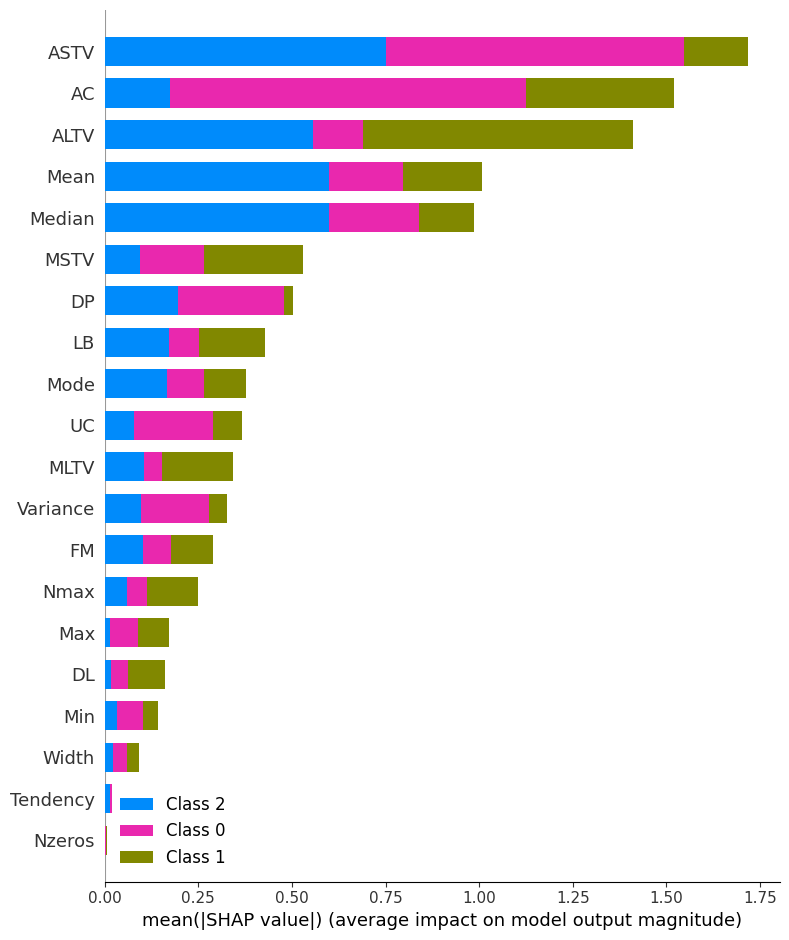

In [29]:
# length of the bar for every feature shows how much that feature influences predictions 
# the colour segments (blue, pink and olive) correspond to each class in the NSP variable
# We are trying to see how strongly each feature pushes predictions toward each class
import shap
explainer = shap.Explainer(model)
shap_values = explainer(X)
shap.summary_plot(shap_values, X)

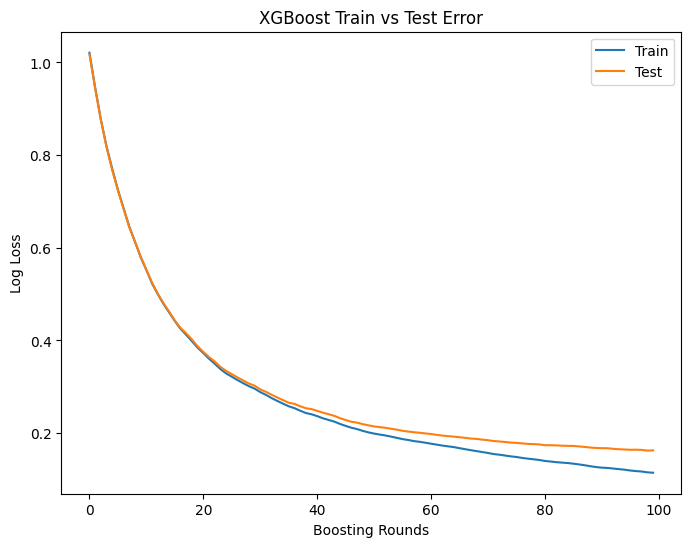

In [30]:
epochs = len(evals_result["validation_0"]["mlogloss"])
x_axis = range(0, epochs)

plt.figure(figsize=(8,6))
plt.plot(x_axis, evals_result["validation_0"]["mlogloss"], label="Train")
plt.plot(x_axis, evals_result["validation_1"]["mlogloss"], label="Test")
plt.xlabel("Boosting Rounds")
plt.ylabel("Log Loss")
plt.title("XGBoost Train vs Test Error")
plt.legend()
plt.show()


Train error is around the same as the Test Error: Implies that the model is not overfitting
If the model was overfitting, test error would have been significantly higher compared to train error.

In [31]:
y_pred = model.predict(X_test)

# Evaluation
print("Accuracy:", accuracy_score(Y_test, y_pred))
print("\nClassification Report:\n", classification_report(Y_test, y_pred))

Accuracy: 0.9357277882797732

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.94      0.96       420
           1       0.74      0.88      0.81        73
           2       0.88      1.00      0.94        36

    accuracy                           0.94       529
   macro avg       0.87      0.94      0.90       529
weighted avg       0.94      0.94      0.94       529



In [32]:
from sklearn.metrics import f1_score

y_true = Y_test
macro_f1 = f1_score(y_true, y_pred, average='macro')
print(macro_f1)


0.9003889804055071


In [33]:
import os
os.makedirs("models", exist_ok=True)   # ✅ creates folder if it doesn't exist

import joblib

# Save the trained model
joblib.dump(model, "models/xgboost_model.joblib")


['models/xgboost_model.joblib']

In [34]:
import joblib

# Save the trained model
joblib.dump(model, "models/xgboost_model.joblib")


['models/xgboost_model.joblib']

In [35]:
X_test.to_csv("test_data.csv", index=False)